In [1]:
import os
import zipfile
import csv
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import time
import warnings
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import *
import sys
%matplotlib inline 
if not sys.warnoptions:
    warnings.simplefilter("ignore")   
from IPython import display, utils

In [2]:
local_zip = '/content/drive/MyDrive/Dataset/NASA_NOAA.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('dataset')

In [3]:
solar_wind = pd.read_csv('/content/dataset/solar_wind.csv')
sunspots = pd.read_csv('/content/dataset/sunspots.csv')

In [ ]:
solar_wind.head()

,period,timedelta,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source
0,train_a,0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,ac
1,train_a,0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,ac
2,train_a,0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,ac
3,train_a,0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,ac
4,train_a,0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,ac


In [ ]:
sunspots.head()

,period,timedelta,smoothed_ssn
0,train_a,0 days 00:00:00,65.4
1,train_a,13 days 00:00:00,72.0
2,train_a,44 days 00:00:00,76.9
3,train_a,74 days 00:00:00,80.8
4,train_a,105 days 00:00:00,85.4


In [ ]:
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

In [ ]:
dst = pd.read_csv("/content/dataset/labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

In [ ]:
print(solar_wind.shape)
print(sunspots.shape)
print(dst.shape)

(8392320, 15)
(192, 1)
(139872, 1)


In [ ]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [ ]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [ ]:
sunspots.groupby("period").describe()

smoothed_ssn                        ...                        
               count       mean        std  ...     50%      75%    max
period                                      ...                        
train_a         40.0  136.90250  34.563168  ...  151.50  164.400  175.2
train_b         72.0   51.85000  39.200266  ...   43.15   91.225  116.4
train_c         80.0   24.31375  19.020414  ...   20.50   38.525   69.5

[3 rows x 8 columns]

In [ ]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(25,60), dpi=200)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot( ax=axes[i],
                          title=f"{key.capitalize()}",
                          rot=30,color='red', lw=2
                        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()

In [ ]:
cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:10000])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
solar_wind.isnull().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

In [ ]:
joined = solar_wind.join(sunspots).join(dst).fillna(method="ffill")

In [ ]:
joined.describe()

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,smoothed_ssn,dst
count,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06,8.392320e+06
mean,-6.782127e-01,1.134599e-01,-2.341137e-02,1.157530e-01,1.938621e+02,-6.780475e-01,9.269831e-02,-2.791417e-02,1.669274e-01,1.940915e+02,5.625723e+00,4.410761e+00,4.301663e+02,1.129632e+05,5.808686e+01,-1.105524e+01
std,3.677222e+00,3.991602e+00,3.369456e+00,3.214008e+01,9.650463e+01,3.675150e+00,3.919035e+00,3.456028e+00,3.329046e+01,9.670139e+01,3.131392e+00,4.461463e+00,1.003519e+02,1.189190e+05,5.245755e+01,1.906926e+01
min,-5.463000e+01,-5.169000e+01,-5.500000e+01,-8.989000e+01,0.000000e+00,-5.463000e+01,-5.268000e+01,-5.569000e+01,-8.991000e+01,0.000000e+00,3.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+00,-3.870000e+02
25%,-3.290000e+00,-2.460000e+00,-1.710000e+00,-2.151000e+01,1.240900e+02,-3.290000e+00,-2.380000e+00,-1.810000e+00,-2.288000e+01,1.246400e+02,3.650000e+00,1.780000e+00,3.566000e+02,3.878700e+04,1.400000e+01,-1.800000e+01
50%,-6.900000e-01,1.200000e-01,1.000000e-02,9.000000e-02,1.765700e+02,-6.900000e-01,9.000000e-02,0.000000e+00,0.000000e+00,1.773500e+02,4.960000e+00,3.310000e+00,4.094000e+02,7.612400e+04,3.890000e+01,-8.000000e+00
75%,2.010000e+00,2.650000e+00,1.690000e+00,2.170000e+01,2.858500e+02,2.010000e+00,2.550000e+00,1.790000e+00,2.315000e+01,2.860000e+02,6.740000e+00,5.670000e+00,4.851400e+02,1.484290e+05,9.640000e+01,0.000000e+00
max,5.555000e+01,5.760000e+01,7.403000e+01,8.994000e+01,3.600000e+02,5.554000e+01,5.388000e+01,7.245000e+01,8.996000e+01,3.600000e+02,8.053000e+01,1.997000e+02,1.198490e+03,6.223700e+06,1.752000e+02,6.700000e+01


In [ ]:
joined.groupby('period').describe().T

period             train_a       train_b       train_c
bx_gse count  1.729440e+06  3.155040e+06  3.507840e+06
       mean  -1.774336e+00 -3.190959e-01 -4.607994e-01
       std    4.334128e+00  3.627893e+00  3.239728e+00
       min   -5.463000e+01 -2.937000e+01 -4.546000e+01
       25%   -4.970000e+00 -3.080000e+00 -2.790000e+00
...                    ...           ...           ...
dst    min   -3.870000e+02 -2.230000e+02 -3.740000e+02
       25%   -2.600000e+01 -1.700000e+01 -1.600000e+01
       50%   -1.200000e+01 -7.000000e+00 -7.000000e+00
       75%   -1.000000e+00  1.000000e+00  0.000000e+00
       max    6.500000e+01  5.900000e+01  6.700000e+01

[128 rows x 3 columns]

<Figure size 3600x5040 with 0 Axes>

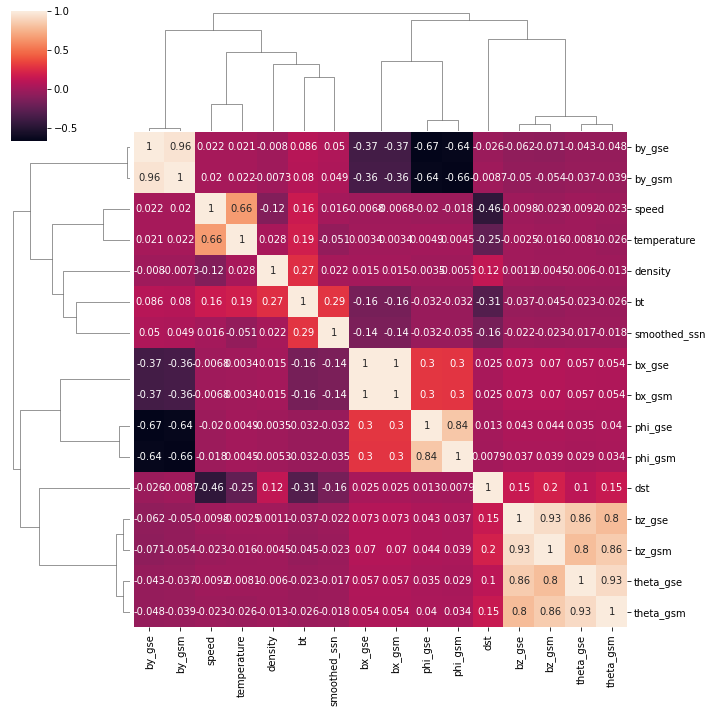

In [ ]:
plt.figure(figsize=(50,70))
sns.clustermap(joined.corr(), annot=True)

In [ ]:
def impute_features(feature_df):
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df

In [ ]:
def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(["period", feature_df.index.get_level_values(1).floor("H")]).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged

In [ ]:
def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]
    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)
    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)
        normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
        )
    # impute missing values
    imputed = impute_features(normalized)
    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [ ]:
SOLAR_WIND_FEATURES = [ "bt", "temperature", "bx_gse", "by_gse", "bz_gse", "speed", "density",]


In [ ]:
XCOLS = ([col + "_mean" for col in SOLAR_WIND_FEATURES]+ [col + "_std" for col in SOLAR_WIND_FEATURES]+ ["smoothed_ssn"])


In [ ]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

(139872, 15)


bt_mean    bt_std  ...  density_std  smoothed_ssn
period  timedelta                            ...                           
train_a 0 days 00:00:00  0.499705  2.443614  ...    -0.205724      0.139444
        0 days 01:00:00  0.547177 -0.224580  ...    -0.058215      0.139444
        0 days 02:00:00  0.739905 -0.770240  ...    -0.220012      0.139444
        0 days 03:00:00  0.699098 -0.278783  ...     0.218373      0.139444
        0 days 04:00:00  0.223933 -0.225168  ...     0.097253      0.139444

[5 rows x 15 columns]

In [ ]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(25,60), dpi=200)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot( ax=axes[i],
                          title=f"{key.capitalize()}",
                          rot=30,color='red', lw=2
                        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()

In [ ]:
cols_to_plot = ["bx_gse_mean","bx_gse_std", "bt_mean", "bt_std", "speed_mean","speed_std", "temperature_mean","temperature_std"]
show_raw_visualization(features[cols_to_plot].iloc[:10000])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
(features.isna().sum() == 0)

bt_mean             True
bt_std              True
temperature_mean    True
temperature_std     True
bx_gse_mean         True
bx_gse_std          True
by_gse_mean         True
by_gse_std          True
bz_gse_mean         True
bz_gse_std          True
speed_mean          True
speed_std           True
density_mean        True
density_std         True
smoothed_ssn        True
dtype: bool

In [ ]:
YCOLS = ["t0", "t1"]

In [ ]:
def process_labels(dst):
    y = dst.copy()
    y["t1"] = y.groupby("period").dst.shift(-1)
    y.columns = YCOLS
    return y

In [ ]:
labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                
train_a 0 days 00:00:00  -7 -10.0
        0 days 01:00:00 -10 -10.0
        0 days 02:00:00 -10  -6.0
        0 days 03:00:00  -6  -2.0
        0 days 04:00:00  -2   3.0

In [ ]:
data = labels.join(features)
data.head()

t0    t1  ...  density_std  smoothed_ssn
period  timedelta                  ...                           
train_a 0 days 00:00:00  -7 -10.0  ...    -0.205724      0.139444
        0 days 01:00:00 -10 -10.0  ...    -0.058215      0.139444
        0 days 02:00:00 -10  -6.0  ...    -0.220012      0.139444
        0 days 03:00:00  -6  -2.0  ...     0.218373      0.139444
        0 days 04:00:00  -2   3.0  ...     0.097253      0.139444

[5 rows x 17 columns]

In [ ]:
data.to_csv("solarwind.csv")